## This notebook presents the creation of an N-layer Quantum Galton Board (QGB) circuit that could be used as an universal statistical simulator. This work was accomplished by team $\textbf{RoQTeam}$ as part of Project 1 (Quantum Walks and Monte Carlo) from Womanium and Wiser summer school 2025. 

In [1]:
from typing import Iterable, Optional, Dict
from math import ceil
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

### We based our method on the article [Univsersal Statistical Simulator](https://arxiv.org/pdf/2202.01735) by Mark Carney and Ben Varcoe. We started from the simple examples of 1, 2 layers presented in the paper and generalized the circuit, giving one the popsibility to implement an N-layer QGB. Compared to a classical Galton Board, the N-layer from our implementation corresponds to a classical variant of N-1 layer.

#### The buling block of the QGB is the peg, which is implemented based on the figure 3 of the paper. The needed operations are, with left, mid, right being the indices of the qubits where the peg is applied, and the ctrl is the index of the control qubit.
- cswap(left, mid)
- CX(mid->ctrl)
- cswap(mid, right)



In [2]:
def peg(qc: QuantumCircuit, q: QuantumRegister, ctrl: int, left: int, mid: int, right: int):
    """    Apply a peg operation on the quantum circuit.
    Args:
        qc (QuantumCircuit): The quantum circuit to apply the peg operation on.
        q (QuantumRegister): The quantum register containing the qubits.
        ctrl (int): The index of the control qubit.
        left (int): The index of the left qubit.
        mid (int): The index of the middle qubit.
        right (int): The index of the right qubit.
    """
    qc.cswap(q[ctrl], q[left], q[mid])
    qc.cx(q[mid], q[ctrl])
    qc.cswap(q[ctrl], q[mid], q[right])

#### The function which is used to construct an N-layer QGB with different settings, depending on the preference of the user. The construction is based on the explanations in the paper and could be used to produce a $\textbf{balanced QGB}$ (uniform 50% probability for each peg in the board), $\textbf{uniform biased QGB}$ (each peg in a layer has the same unique probability) and a $\textbf{fine grained QGB}$ (each peg has an probability which can be individually controlled).


In [3]:
def build_qgb(
    n_layers: int,
    thetas: Optional[Iterable[float]] = None,
    fine_grained: bool = False,
    measure: bool = True,
) -> QuantumCircuit:
    """Build a Quantum Galton Board (QGB) circuit.      
    Args:
        n_layers (int): Number of layers in the QGB.
        thetas (Optional[Iterable[float]]): Angles for the control qubit in each layer.
            If `fine_grained` is True, this should be a list of angles for each peg in the layers.
            If `fine_grained` is False, this should be a list of angles for each layer.
        fine_grained (bool): If True, allows for fine-grained control of angles for each peg.
            If False, uses a single angle for each layer.
        measure (bool): If True, adds measurement operations to the circuit.
    Returns:
        QuantumCircuit: The constructed QGB circuit.
    Raises:
        ValueError: If `n_layers` is less than 1, or if the length of `thetas` is not appropriate for the specified `n_layers` and `fine_grained`.
    """
    if n_layers < 1:
        raise ValueError("n_layers >= 1 required")

    L = 2 * n_layers + 1            # number of position sites
    ctrl_idx = 0
    pos_start = 1                   # positions live at q[1..L]
    center = pos_start + n_layers   # middle site index

    q = QuantumRegister(1 + L, "q")
    qc = QuantumCircuit(q, name=f"QGB_{n_layers}")

    # place the 'ball' at the center site (Fig. 3 / Sec. 3.1) 
    qc.x(q[center])
    
    if fine_grained:
        theta_list = list(thetas) if thetas is not None else [None] * (n_layers)*(n_layers+1)/2
        if len(theta_list) != (n_layers)*(n_layers+1)/2:
            raise ValueError("thetas length is not appropiate")
    else:
        theta_list = list(thetas) if thetas is not None else [None] * n_layers
        if len(theta_list) != n_layers:
            raise ValueError("thetas length must equal n_layers")

    if fine_grained:
        indeces = 0
        theta_list_reshape = []
        for k in range(n_layers):
            temp = []
            for i in range(k+1):
                temp.append(theta_list[indeces])
                indeces += 1
            theta_list_reshape.append(temp)
            # print(len(temp))
            
        for r in range(1, n_layers+1):
        # for r1 in range(10):
            row_thetas = list(theta_list_reshape[r-1])
            if len(row_thetas) != r:
                raise ValueError(f"row {r}: need {r} angles, got {len(row_thetas)}")

            
            mids = list(range(center - (r - 1), center + (r - 1) + 1, 2))
            
            # qc.reset(q[ctrl_idx])  # reset control qubit
            for i, m in enumerate(mids):
                qc.reset(q[ctrl_idx])
                qc.rx(row_thetas[i], q[ctrl_idx])
                left, mid, right = m - 1, m, m + 1
                peg(qc, q, ctrl_idx, left, mid, right)
                
                # if i < len(mids) - 2:
                #     qc.cx(q[right], q[ctrl_idx])
                # elif i == len(mids) - 2:
                #     qc.reset(q[ctrl_idx])
                #     qc.rx(row_thetas[-1], q[ctrl_idx])
            qc.barrier()
            for rgt in (m+2 for m in mids[:-1]):
                qc.cx(q[rgt], q[rgt - 1])
                qc.reset(q[rgt])
                

            
            # print(len(row_thetas))
        
    else:
        # iterate rows (Sec. 3.2–3.3). Reset control and prepare coin each row. 
        for r in range(1, n_layers):
            # reset + coin on control for this row (H or Rx for bias; Sec. 5.1) 
            qc.reset(q[ctrl_idx])
            if theta_list[r - 1] is None:
                qc.h(q[ctrl_idx])
            else:
                qc.rx(theta_list[r - 1], q[ctrl_idx])

            # pegs at middle sites spaced by 2 across the row: m = center-(r-1) ... center+(r-1) (step 2)
            mids = list(range(center - (r - 1), center + (r - 1) + 1, 2))
            for i, m in enumerate(mids):
                left, mid, right = m - 1, m, m + 1
                peg(qc, q, ctrl_idx, left, mid, right)
                if i < len(mids) - 1:                       # corrective rebalance before next peg
                    qc.cx(q[right], q[ctrl_idx])  

    # optional measurements of every position site (Sec. 4.1, 4.3) 
    if measure:
        qc.barrier()  # optional barrier before measurement
        c = ClassicalRegister(L, "c")
        qc.add_register(c)
        # map pos q[1..L] -> c[0..L-1] with c[0] the leftmost bin and c[-1] the rightmost
        for i in range(L):
            qc.measure(q[pos_start + i], c[i])

    return qc

#### Wrapper function that constructs a QGB and returns the measurements results. The results in the returned dictionary are post-processed accordingly to the instructions given in the paper.

In [4]:
def sample_qgb(n_layers: int, shots: int = 20000, thetas: Optional[Iterable[float]] = None, fine_grained: Optional[bool] = False) -> Dict[int, int]:
    """Sample a Quantum Galton Board (QGB) circuit and return the measurement results.
    Args:
        n_layers (int): Number of layers in the QGB.
        shots (int): Number of shots to run the circuit.
        thetas (Optional[Iterable[float]]): Angles for the control qubit in each layer.
            If `fine_grained` is True, this should be a list of angles for each peg in the layers.
            If `fine_grained` is False, this should be a list of angles for each layer.
        fine_grained (bool): If True, allows for fine-grained control of angles for each peg.
            If False, uses a single angle for each layer.
    Returns:
        Dict[str, int]: A dictionary where keys are the number of rights (0 to n_layers) and values are the counts of occurrences.
        List[str]: A list of memory strings from the simulation, representing the measurement results.
    """
    qc = build_qgb(n_layers, thetas=thetas, fine_grained=fine_grained, measure=True)
    backend = Aer.get_backend("aer_simulator")
    res = backend.run(qc, shots=shots, memory=True).result()
    counts = res.get_counts()
    memory = res.get_memory()
    # bitstrings are length L with c[0] the leftmost site. Find the '1' position.
    hist: Dict[int, int] = {}
    n = n_layers
    for bitstr, c in counts.items():
        # Aer returns little-endian classical strings; reverse to align c[0]..c[L-1]
        s = bitstr[::-1]
        j = s.index("1")  # exactly one '1' expected on ideal circuit (Sec. 3.4) 
        k = j - n         # map site j∈[0..2n] to bin offset in [-n..+n]
        # classical GB bins are 0..n for number of rights; convert: rights = (k + n)//2
        rights = (k + n) // 2
        hist[rights] = hist.get(rights, 0) + c
    return dict(sorted(hist.items())), memory


#### Construct and display some test circuits for 4 layer QGB.

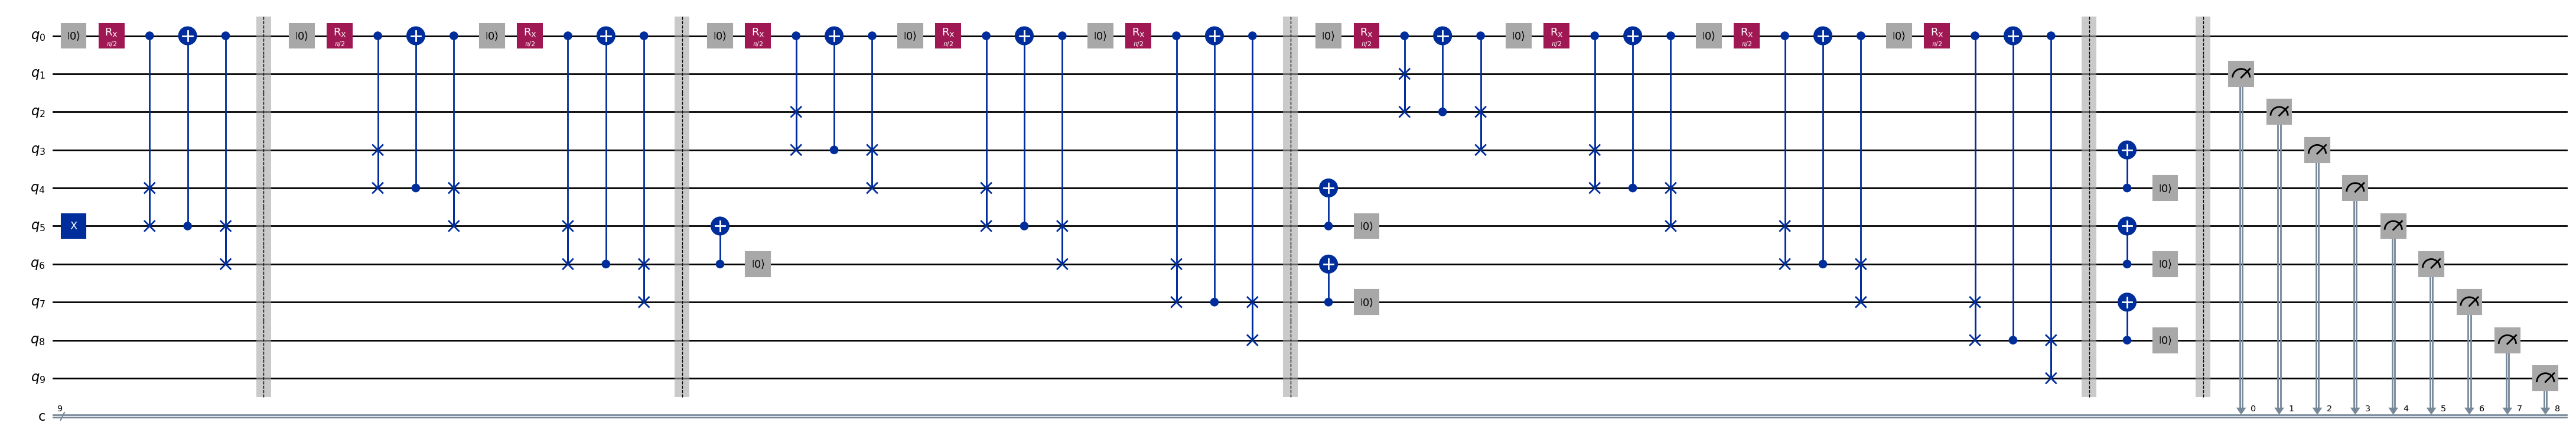

In [5]:
N = 4  # number of layers
# Uniform 4-layer
# qc = build_qgb(N, thetas=[None for i in range(N)], fine_grained=False, measure=True)

# Uniform biased 4-layer
# qc = build_qgb(N, thetas=[np.pi/2 for i in range(N)], fine_grained=False, measure=True)


#Fine grained 4-layer
qc = build_qgb(N, thetas=[np.pi/2 for _ in range((N)*(N+1)//2)], fine_grained=True, measure=True)
qc.draw(output='mpl', fold=100)

#### Display the results obtained after simulating a circuit consisting of an uniform 6-layer QGB. Naturally, it produces a uniform distribution, as can be seen in the figure below. The number of elements in the results is the same as it would be produced by a classical Galton Board with 5 layers.

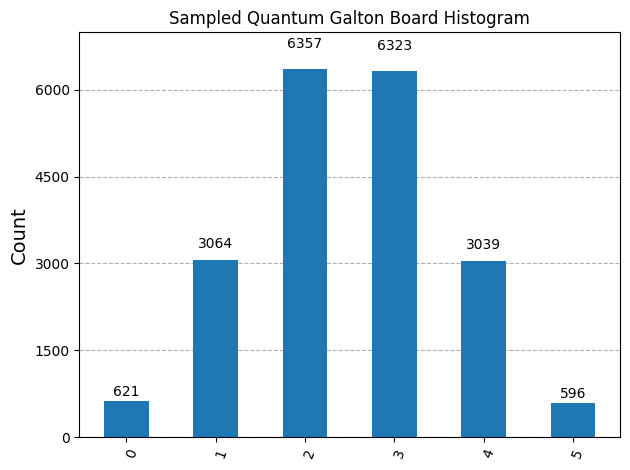

In [6]:
N = 6
res_uniform_6_layer, res_uniform_6_layer_mems = sample_qgb(N, shots=20000, thetas=[None for _ in range(N)], fine_grained=False)
plot_histogram(res_uniform_6_layer, title="Sampled Quantum Galton Board Histogram", bar_labels=True) 

#### In order to create a larger distribution, we have created the required functions, as described in the paper. Instead of taking just the distribution from the histrogram that is obtained after the measurement is performed, we take each individual result using the memory result. Thus, we can group individual measurement results by summing the current result and thus enlarging the current distribution. For example, for N=6 we get the counts with values: 0, 1, 2, 3, 4, 5. Summing the results in sums of 8, we get counts in the range 0 - 40.

In [7]:
def onehot_to_rights(bitstr: str, n_layers: int) -> int:
    """Aergorithm to map a one-hot position over L=2n+1 bits to the classical GB bin 0..n.
    Args:
        bitstr (str): A one-hot encoded string of length L=2n+1.
        n_layers (int): The number of layers in the Quantum Galton Board.
    Returns:
        int: The number of rights (0 to n_layers) corresponding to the one-hot position.
    """
    s = bitstr[::-1]               # align with c[0]..c[L-1]
    j = s.index("1")               # one '1' expected
    return j // 2         

def blocksums(vals, block=8):
    """Compute the block sums of a list of values.
    Args:
        vals (list): List of values to compute block sums for.
        block (int): Size of each block to sum.
    Returns:
        list: List of block sums.
    """
    
    k = len(vals) - (len(vals) % block)  # drop tail
    return [sum(vals[i:i+block]) for i in range(0, k, block)]

def compute_block_sums(N: int, block_size: int, mems: Iterable[str]) -> Dict[int, int]:
    """Compute the block sums of the one-hot encoded memory strings from the QGB simulation.
    Args:
        N (int): Number of layers in the Quantum Galton Board.
        block_size (int): Size of each block to sum.
        mems (Iterable[str]): Iterable of one-hot encoded memory strings from the QGB simulation.
    Returns:
        Dict[int, int]: A dictionary where keys are the block sums and values are their counts.
    """
    from collections import Counter
    per_shot_vals = [onehot_to_rights(b, N) for b in mems]  # each in {0,1,2,...,N}
    block8_sums = blocksums(per_shot_vals, block=block_size)  # each in {0..8N}
    return Counter(block8_sums)


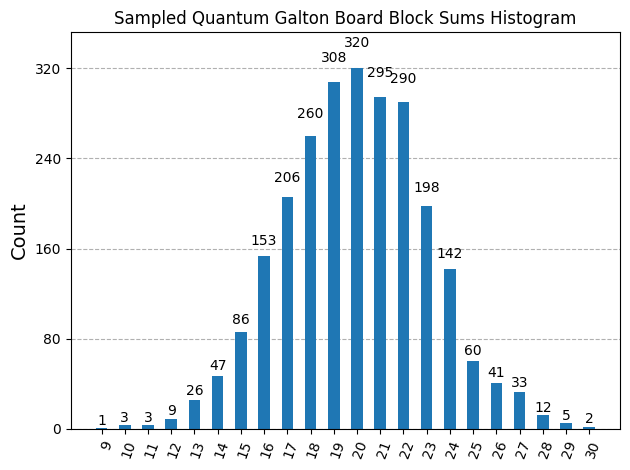

In [12]:
N = 6
hist32_res_uniform_6_layer = compute_block_sums(N, block_size=8, mems=res_uniform_6_layer_mems)
plot_histogram(hist32_res_uniform_6_layer, title="Sampled Quantum Galton Board Block Sums Histogram")

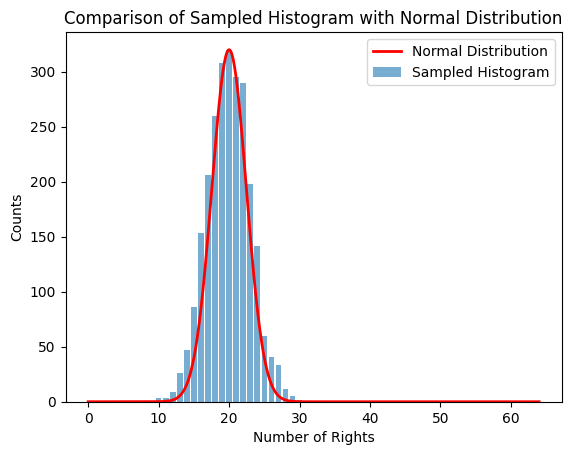

In [13]:
def compare_histogram_with_normal_distribution(hist: Dict[int, int], n_layers: int, shots: int, block_size: int = 8):
    """Compare the sampled histogram with a normal distribution.
    Args:        
        hist (Dict[int, int]): The histogram of sampled rights.
        n_layers (int): Number of layers in the Quantum Galton Board.
        shots (int): Number of shots used in the simulation.
        block_size (int): Size of each block to sum.
    """
    import matplotlib.pyplot as plt
    from scipy.stats import norm

    n_layers = n_layers - 1
    mu = block_size * (n_layers) // 2
    variance = n_layers + 1
    sigma = np.sqrt(variance)
    x = np.arange(0, 2**(n_layers + 1), 0.0001)
    max_value_hist = max(hist.values())
    
    
    y = norm.pdf(x, mu, sigma)  # scale to number of shots
    y = y / y.max()
    y = y * (max_value_hist)  # scale to number of shots

    plt.bar(hist.keys(), hist.values(), width=0.8, label='Sampled Histogram', alpha=0.6)
    plt.plot(x, y, 'r-', label='Normal Distribution', linewidth=2)
    plt.xlabel('Number of Rights')
    plt.ylabel('Counts')
    plt.title('Comparison of Sampled Histogram with Normal Distribution')
    plt.legend()
    plt.show()
    
N = 6
compare_histogram_with_normal_distribution(hist32_res_uniform_6_layer, N, 80000, block_size=8)

#### We observe that if we use instead of an uniform QGB a uniform biased QGB where each theta angle is $\frac{\pi}{2}$, we get the same results.

In [14]:
res_uniform_5_layer, res_uniform_5_layer_mems = sample_qgb(n_layers=5, shots=80000, thetas=[np.pi/2 for i in range(5)])

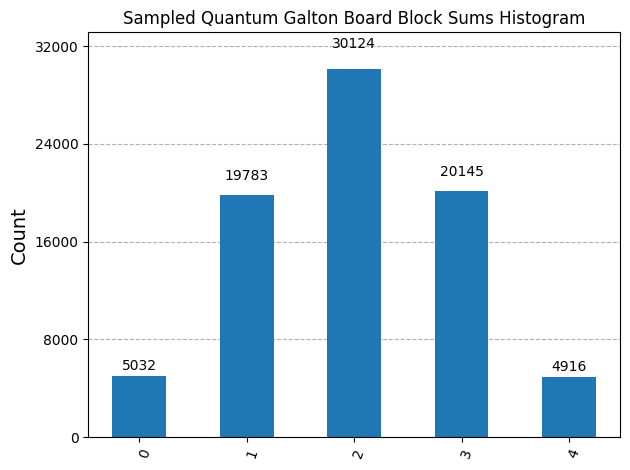

In [15]:
plot_histogram(res_uniform_5_layer, title="Sampled Quantum Galton Board Block Sums Histogram")

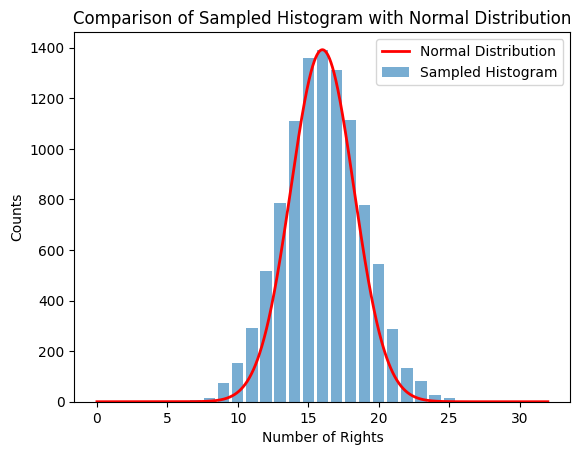

In [16]:
hist32_res_uniform_5_layer = compute_block_sums(N=5, block_size=8, mems=res_uniform_5_layer_mems)
compare_histogram_with_normal_distribution(hist32_res_uniform_5_layer, n_layers=5, shots=80000, block_size=8)

#### As the fine grained QGB could be used to create any distribution, we create a function that caltulates the needed thetas for obtaining an exponential distribution with specific properties. Thus, we change the classic QGB where each peg has a 50% probability to pegs that are controlled individually based on the required probabilities for an exponential distribution.

In [17]:
def exponential_distribution_thetas(n_layers: int, lmbda: float = 0.8, direction: str = 'right') -> list[float]:
    """
    Generate bias angles for exponential distribution approximation.
    
    Args:
        n_layers: Number of QGB layers
        lmbda: Exponential decay parameter (controls steepness)
        direction: 'right' for right-skewed, 'left' for left-skewed
    
    Returns:
        List of theta angles for Rx gates
    """
    thetas = []
    
    for i in range(int((n_layers)*(n_layers+1)/2)):
        # Create increasing bias toward one side
        # For exponential decay, we want higher probability of going in one direction
        if direction == 'right':
            # Increasing rightward bias
            bias_strength = 1 - np.exp(-lmbda * (i + 1) / n_layers)
            # Convert bias to theta: p_right = cos^2(theta/2)
            theta = 2 * np.arccos(np.sqrt(bias_strength))
        else:  # left
            bias_strength = 1 - np.exp(-lmbda * (i + 1) / n_layers)
            theta = 2 * np.arccos(np.sqrt(1 - bias_strength))
            
        thetas.append(theta)

    thetas = thetas[-1::-1]        
    
    return thetas

In [18]:
def compare_with_exponential(hist: Dict[int, int], n_layers: int, lmbda: float):
    """Compare the sampled histogram with a theoretical exponential distribution.
    Args:
        hist (Dict[int, int]): The histogram of sampled rights.
        n_layers (int): Number of layers in the Quantum Galton Board.
        lmbda (float): Exponential decay parameter.
    """
    import matplotlib.pyplot as plt
    from scipy.stats import expon
    
    # Theoretical exponential
    x_theory = np.arange(0, n_layers + 1)
    # Scale exponential to discrete bins
    exp_theory = expon.pdf(x_theory, scale=1/lmbda)
    exp_theory = exp_theory / np.sum(exp_theory)  # Normalize
    
    # Scale to match histogram counts
    total_counts = sum(hist.values())
    exp_theory_scaled = exp_theory * total_counts
    
    plt.figure(figsize=(10, 6))
    plt.bar(hist.keys(), hist.values(), alpha=0.6, label='QGB Exponential', width=0.8)
    plt.plot(x_theory, exp_theory_scaled, 'r-o', label=f'Theoretical Exp(λ={lmbda})', linewidth=2)
    plt.xlabel('Bin (Number of Rights)')
    plt.ylabel('Counts')
    plt.title('Quantum Galton Board: Exponential Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

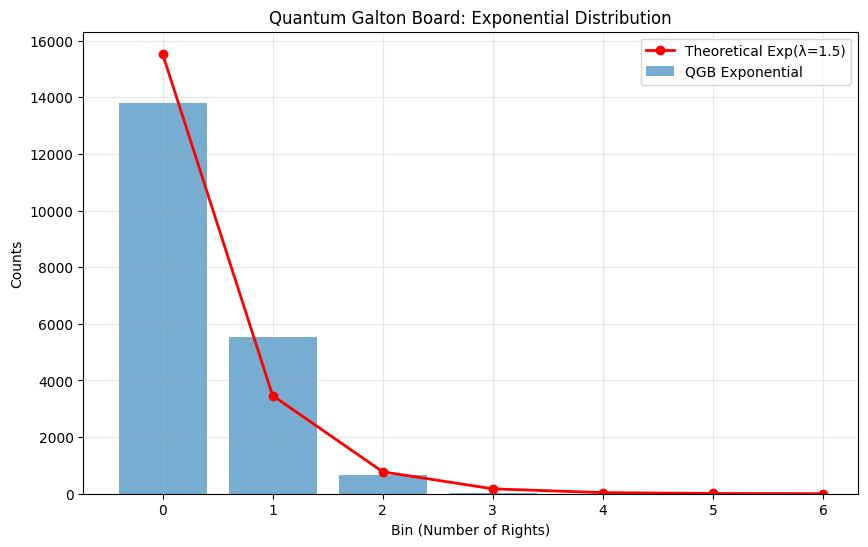

In [19]:
def test_exponential_distribution(n_layers: int = 6, lmbda: float = 1.5):
    """Test the Quantum Galton Board with exponential distribution bias.
    Args:
        n_layers (int): Number of layers in the Quantum Galton Board.
        lmbda (float): Exponential decay parameter.
    Returns:
        Dict[int, int]: A dictionary where keys are the number of rights (0 to n_layers) and values are the counts of occurrences.
    """
    n_layers = n_layers
    lmbda = lmbda  
    
    # Generate exponential bias angles
    exp_thetas = exponential_distribution_thetas(n_layers, lmbda, 'left')
    
    # Run the QGB with exponential bias
    hist, memory = sample_qgb(n_layers, shots=20000, thetas=exp_thetas, fine_grained=True)
    
    # Compare with theoretical exponential distribution
    compare_with_exponential(hist, n_layers, lmbda)
    
    return hist

n_layers = 6
hist_exp_distribution_6_layers = test_exponential_distribution(n_layers=n_layers, lmbda=1.5)

#### Based om the same principle, we constructed a circuit that build a quantum walk. Quantum walks generalize classical random walks by evolving a quantum state over graph nodes using unitary operators, allowing superposition and interference of paths. By means of interference, the distribution resulted from a quantum walk will be different to the one obtained from a classical random walk.

In [18]:
def build_hadamard_quantum_walk(n_steps: int, measure: bool = True) -> QuantumCircuit:
    """Build a Hadamard quantum walk circuit.
    Args:
        n_steps (int): Number of walk steps.
        measure (bool): Whether to add measurements.
    Returns:
        QuantumCircuit: The constructed Hadamard quantum walk circuit.
    """
    # Position register needs enough qubits to represent all possible positions
    position_qubits = n_steps + 1  # Enough for -n_steps to +n_steps
    coin_qubit = 1
    
    total_qubits = position_qubits + coin_qubit
    
    q = QuantumRegister(total_qubits, "q")
    qc = QuantumCircuit(q, name=f"HadamardWalk_{n_steps}")
    
    # Initialize walker at center position
    center_pos = position_qubits // 2
    qc.x(q[center_pos])  # Place walker at center
    
    
    for step in range(n_steps):
        # Step 1: Hadamard coin operator
        qc.h(q[0])  # Coin qubit is q
        
        coin = q[0]
        pos = [q[i + 1] for i in range(position_qubits)]

        # Right shift when coin = |1|: ripple high -> low using CSWAPs
        for i in range(position_qubits - 1, 0, -1):
            qc.cswap(coin, pos[i], pos[i - 1])

        # Left shift when coin = |0|: flip control sense with X, ripple low -> high
        qc.x(coin)
        for i in range(position_qubits - 1):
            qc.cswap(coin, pos[i], pos[i + 1])
        qc.x(coin)

        qc.barrier()
    
    # Measurements
    if measure:
        c = ClassicalRegister(position_qubits, "c")
        qc.add_register(c)
        for i in range(position_qubits):
            qc.measure(q[i + 1], c[i])  # Skip coin qubit in measurement
    
    return qc




#### Wrapper function that constructs a quantum circuit that performs a quantum walk and returns the measurement results.

In [5]:
def sample_hadamard_walk(n_steps: int, shots: int = 10000) -> Dict[int, int]:
    """Sample a Hadamard quantum walk circuit and return the measurement results.
    Args:
        n_steps (int): Number of walk steps.
        shots (int): Number of measurement shots.
    Returns:
        Dict[int, int]: A dictionary where keys are the number of rights (0 to n_steps) and values are the counts of occurrences.
    """
    
    qc = build_hadamard_quantum_walk(n_steps, measure=True)
    backend = Aer.get_backend("aer_simulator")
    res = backend.run(qc, shots=shots, memory=True).result()
    counts = res.get_counts()
    
    # Convert bit strings to positions
    hist: Dict[int, int] = {}
    position_qubits = n_steps + 1
    center = position_qubits // 2
    
    for bitstr, count in counts.items():
        # Find the position of the '1' in the bit string
        s = bitstr[::-1]  # Reverse for correct indexing
        try:
            pos_idx = s.index("1")
            # Convert to relative position from center
            position = pos_idx - center
            hist[position] = hist.get(position, 0) + count
        except ValueError:
            # No '1' found, skip this measurement
            continue
    
    return dict(sorted(hist.items()))

#### Function that compares the results from a quantum walk with the results from classical walks

In [4]:
def compare_quantum_walk_theory(hist: Dict[int, int], n_steps: int):
    """Compare quantum walk results with theoretical expectations.
    Args:
        hist (Dict[int, int]): The histogram of sampled rights.
        n_steps (int): Number of walk steps.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    positions = list(hist.keys())
    counts = list(hist.values())
    
    
    plt.figure(figsize=(12, 6))
    plt.bar(positions, counts, alpha=0.7, label='Hadamard Quantum Walk', width=0.8)
    
    # Add theoretical envelope (simplified)
    x_theory = np.linspace(min(positions), max(positions), 100)
    # Quantum walk envelope roughly follows a spreading pattern
    envelope = np.exp(-x_theory**2 / (2 * n_steps)) * max(counts)
    plt.plot(x_theory, envelope, 'r--', label='Classical Random Walk Envelope', linewidth=2)
    
    plt.xlabel('Position')
    plt.ylabel('Counts')
    plt.title(f'Hadamard Quantum Walk after {n_steps} steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate spreading (variance)
    total_counts = sum(counts)
    mean_pos = sum(p * c for p, c in zip(positions, counts)) / total_counts
    variance = sum((p - mean_pos)**2 * c for p, c in zip(positions, counts)) / total_counts
    spreading = np.sqrt(variance)

    print(f"Mean position: {mean_pos:.3f}")
    print(f"Variance: {variance:.3f}")
    print(f"Spreading (σ): {spreading:.3f}")
    print(f"Theoretical quantum spreading ~ O(n): {n_steps}")
    print(f"Classical would be ~ O(√n): {np.sqrt(n_steps):.3f}")


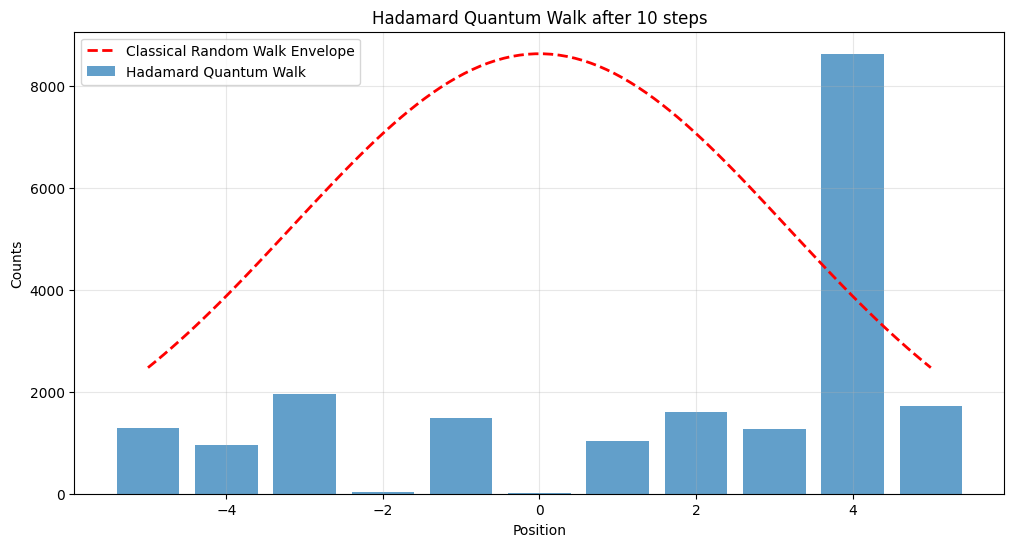

Mean position: 1.675
Variance: 10.525
Spreading (σ): 3.244
Theoretical quantum spreading ~ O(n): 10
Classical would be ~ O(√n): 3.162


In [19]:
n_steps = 10
qw_hist = sample_hadamard_walk(n_steps, shots=20000)
compare_quantum_walk_theory(qw_hist, n_steps)